In [1]:
import numpy as np
from scipy.ndimage.filters import generic_filter as gf
from PIL import Image
import matplotlib.pyplot as plt
import scipy
from scipy import ndimage
import scipy.stats.mstats as ms
import scipy.ndimage.morphology as morph
Image.MAX_IMAGE_PIXELS = None
import math

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\parentpoller.py:116: UserWarning: Parent poll failed.  If the frontend dies,
                the kernel may be left running.  Please let us know
                about your system (bitness, Python, etc.) at
                ipython-dev@scipy.org
  ipython-dev@scipy.org""")


In [2]:
def create_circular_mask(radius):
    kernel = np.zeros((2*radius+1, 2*radius+1))
    y,x = np.ogrid[-radius:radius+1, -radius:radius+1]
    mask = x**2 + y**2 <= radius**2
    mask[radius][radius] = 0
    kernel[mask] = 1
    return kernel

In [3]:
def create_conic_mask(radius, direction):
    kernel = np.zeros((2*radius+1, 2*radius+1))
    y,x = np.ogrid[-radius:radius+1, -radius:radius+1]
    
    if direction == 0: #topright
        mask = (x > y) & (x < abs(y)) & (x**2 + y**2 <= radius**2) & (x > 0)
    elif direction == 1: #righttop
        mask = (x > abs(y)) & (x**2 + y**2 <= radius**2) & (y < 0)
    elif direction == 2: #rightbottom
        mask = (x > abs(y)) & (x**2 + y**2 <= radius**2) & (y > 0)
    elif direction == 3: #bottomright
        mask = (abs(x) < y) & (x**2 + y**2 <= radius**2) & (x > 0)
    elif direction == 4: #bottomleft
        mask = (abs(x) < y) & (x**2 + y**2 <= radius**2) & (x < 0)
    elif direction == 5: #leftbottom
        mask = (abs(x) > abs(y)) & (x < abs(y)) & (x**2 + y**2 <= radius**2) & (y > 0)
    elif direction == 6: #lefttop
        mask = (abs(x) > abs(y)) & (x < abs(y)) & (x**2 + y**2 <= radius**2) & (y < 0)
    elif direction == 7: #topleft
        mask = (x > y) & (x < abs(y)) & (x**2 + y**2 <= radius**2) & (x < 0)
    kernel[mask] = 1
    return kernel

def conicMean(arr, maskRadius, threshold):
    masks = []
    for i in range(0, 8):
        masks.append(create_conic_mask(maskRadius, i))
    newArr = arr.copy()
    amountOfThresholds = 0
    for i in range(len(arr)):
        for j in range(len(arr[i])):
            topRight = meanFromMask(arr, (i, j), masks[0])
            rightTop = meanFromMask(arr, (i, j), masks[1])
            rightBottom = meanFromMask(arr, (i, j), masks[2])
            bottomRight = meanFromMask(arr, (i, j), masks[3])
            bottomLeft = meanFromMask(arr, (i, j), masks[4])
            leftBottom = meanFromMask(arr, (i, j), masks[5])
            leftTop = meanFromMask(arr, (i, j), masks[6])
            topLeft = meanFromMask(arr, (i, j), masks[7])
            if topRight < threshold:
                if bottomLeft < threshold:
                    amountOfThresholds += 1
                    newArr[i][j] = 0.95 * (topRight if topRight < bottomLeft else bottomLeft)
            
            elif rightTop < threshold:
                if leftBottom < threshold:
                    amountOfThresholds += 1
                    newArr[i][j] = 0.95 * (leftBottom if leftBottom < rightTop else rightTop)
            
            elif rightBottom < threshold:
                if leftTop < threshold:
                    amountOfThresholds += 1
                    newArr[i][j] = 0.95 * (rightBottom if rightBottom < leftTop else leftTop)
            
            elif bottomRight < threshold:
                if topLeft < threshold:
                    amountOfThresholds += 1
                    newArr[i][j] = 0.95 * (bottomRight if bottomRight < topLeft else topLeft)
            if newArr[i][j] > arr[i][j]:
                newArr[i][j] = arr[i][j]
    print(amountOfThresholds)        
    return newArr

def meanFromMask(arr, index, mask):
    elementAmount = 0
    row = index[0]
    col = index[1]
    
    halfMask = len(mask) // 2
    
    arrLenRow = len(arr)
    arrLenCol = len(arr[row])
    
    elementSum = 0
    for i in range(-halfMask , halfMask):
        for j in range(-halfMask , halfMask):
            if arrLenCol > col + j + 1 or col + j + 1 >= 0 or arrLenRow > row + i + 1 or row + i + 1 >= 0:
                if mask[i + halfMask][j + halfMask] == 1:
                    if row + i + 1 < arrLenRow:
                        if col + j + 1 < arrLenCol:
                            elementSum += arr[row + i][col + j]
                            elementAmount += 1
    return elementSum / elementAmount if elementAmount != 0 else 0.99

In [95]:
def createOpposingMask(radius, distance, direction):    
    x = np.arange(0, (distance + radius)*2)
    y = np.arange(0, (distance + radius)*2)
    
    pointFromCenter = math.sqrt((distance + radius)**2/2)
    
    if direction == 0: #topleft
        mask = (x[np.newaxis,:]-pointFromCenter + radius)**2 + (y[:,np.newaxis]-pointFromCenter + radius)**2 < radius**2
    elif direction == 1: #topright
        mask = (x[np.newaxis,:]- pointFromCenter - distance)**2 + (y[:,np.newaxis]-pointFromCenter + radius)**2 < radius**2
    elif direction == 2: #bottomright
        mask = (x[np.newaxis,:]- pointFromCenter - distance)**2 + (y[:,np.newaxis]-pointFromCenter - distance)**2 < radius**2
    elif direction == 3: #bottomleft
        mask = (x[np.newaxis,:]- pointFromCenter + radius)**2 + (y[:,np.newaxis]- pointFromCenter - distance)**2 < radius**2
    elif direction == 4: #left
        mask = (x[np.newaxis,:]- radius)**2 + (y[:,np.newaxis]- distance - radius)**2 < radius**2
    elif direction == 5: #top
        mask = (x[np.newaxis,:]- distance - radius)**2 + (y[:,np.newaxis] - radius)**2 < radius**2
    elif direction == 6: #right
        mask = (x[np.newaxis,:]- distance * 2 - radius)**2 + (y[:,np.newaxis]- distance - radius)**2 < radius**2
    elif direction == 7: #bottom
        mask = (x[np.newaxis,:]- distance - radius)**2 + (y[:,np.newaxis]- distance*2 - radius)**2 < radius**2
    return mask


def OpposingCircleFilter(arr, maskRadius, distance, threshold):
    masks = []
    for i in range(0, 8):
        masks.append(createOpposingMask(maskRadius, distance, i))
    newArr = arr.copy()
    updatedElements = 0
    for i in range(len(arr)):
        print(i)
        for j in range(len(arr[i])):
            values = productFromMask(arr, (i, j), masks)
            vertical = (values[5] + values[7]) / 2
            horizontal = (values[4] + values[6]) / 2
            diagonalDown = (values[0] + values[2]) / 2
            diagonalUp = (values[3] + values[1]) / 2
            lowest = min(vertical, horizontal, diagonalUp, diagonalDown)
            if (lowest < newArr[i][j] and lowest < threshold):
                updatedElements += 1
            #print(lowest)
            #print(newArr[i][j])
            #print("\n")
            if lowest < threshold:
                newArr[i][j] = min(lowest * 0.99, newArr[i][j])
    print(updatedElements)
    return newArr

def productFromMask(arr, index, mask):
    row = index[0]
    col = index[1]
    
    halfMask = len(mask[0]) // 2
    
    arrLenRow = len(arr)
    arrLenCol = len(arr[row])
    
    values = np.ones(8)
    elementAmounts = np.ones(8)
    
    for i in range(-halfMask , halfMask):
        for j in range(-halfMask , halfMask):
            if arrLenCol > col + j + 1 or col + j + 1 >= 0 or arrLenRow > row + i + 1 or row + i + 1 >= 0:
                if mask[0][i + halfMask][j + halfMask] == 1:
                    if row + i + 1 < arrLenRow:
                        if col + j + 1 < arrLenCol:
                            values[0] += arr[row + i][col + j]
                            elementAmounts[0] += 1
                elif mask[1][i + halfMask][j + halfMask] == 1:
                    if row + i + 1 < arrLenRow:
                        if col + j + 1 < arrLenCol:
                            values[1] += arr[row + i][col + j]
                            elementAmounts[1] += 1
                elif mask[2][i + halfMask][j + halfMask] == 1:
                    if row + i + 1 < arrLenRow:
                        if col + j + 1 < arrLenCol:
                            values[2] += arr[row + i][col + j]
                            elementAmounts[2] += 1
                elif mask[3][i + halfMask][j + halfMask] == 1:
                    if row + i + 1 < arrLenRow:
                        if col + j + 1 < arrLenCol:
                            values[3] += arr[row + i][col + j]
                            elementAmounts[3] += 1
                elif mask[4][i + halfMask][j + halfMask] == 1:
                    if row + i + 1 < arrLenRow:
                        if col + j + 1 < arrLenCol:
                            values[4] += arr[row + i][col + j]
                            elementAmounts[4] += 1
                elif mask[5][i + halfMask][j + halfMask] == 1:
                    if row + i + 1 < arrLenRow:
                        if col + j + 1 < arrLenCol:
                            values[5] += arr[row + i][col + j]
                            elementAmounts[5] += 1
                elif mask[6][i + halfMask][j + halfMask] == 1:
                    if row + i + 1 < arrLenRow:
                        if col + j + 1 < arrLenCol:
                            values[6] += arr[row + i][col + j]
                            elementAmounts[6] += 1
                elif mask[7][i + halfMask][j + halfMask] == 1:
                    if row + i + 1 < arrLenRow:
                        if col + j + 1 < arrLenCol:
                            values[7] += arr[row + i][col + j]
                            elementAmounts[7] += 1
    for i in range(len(values)):
        values[i] = values[i] / elementAmounts[i] if elementAmounts[i] != 0 else 0.99
    return values
    
    

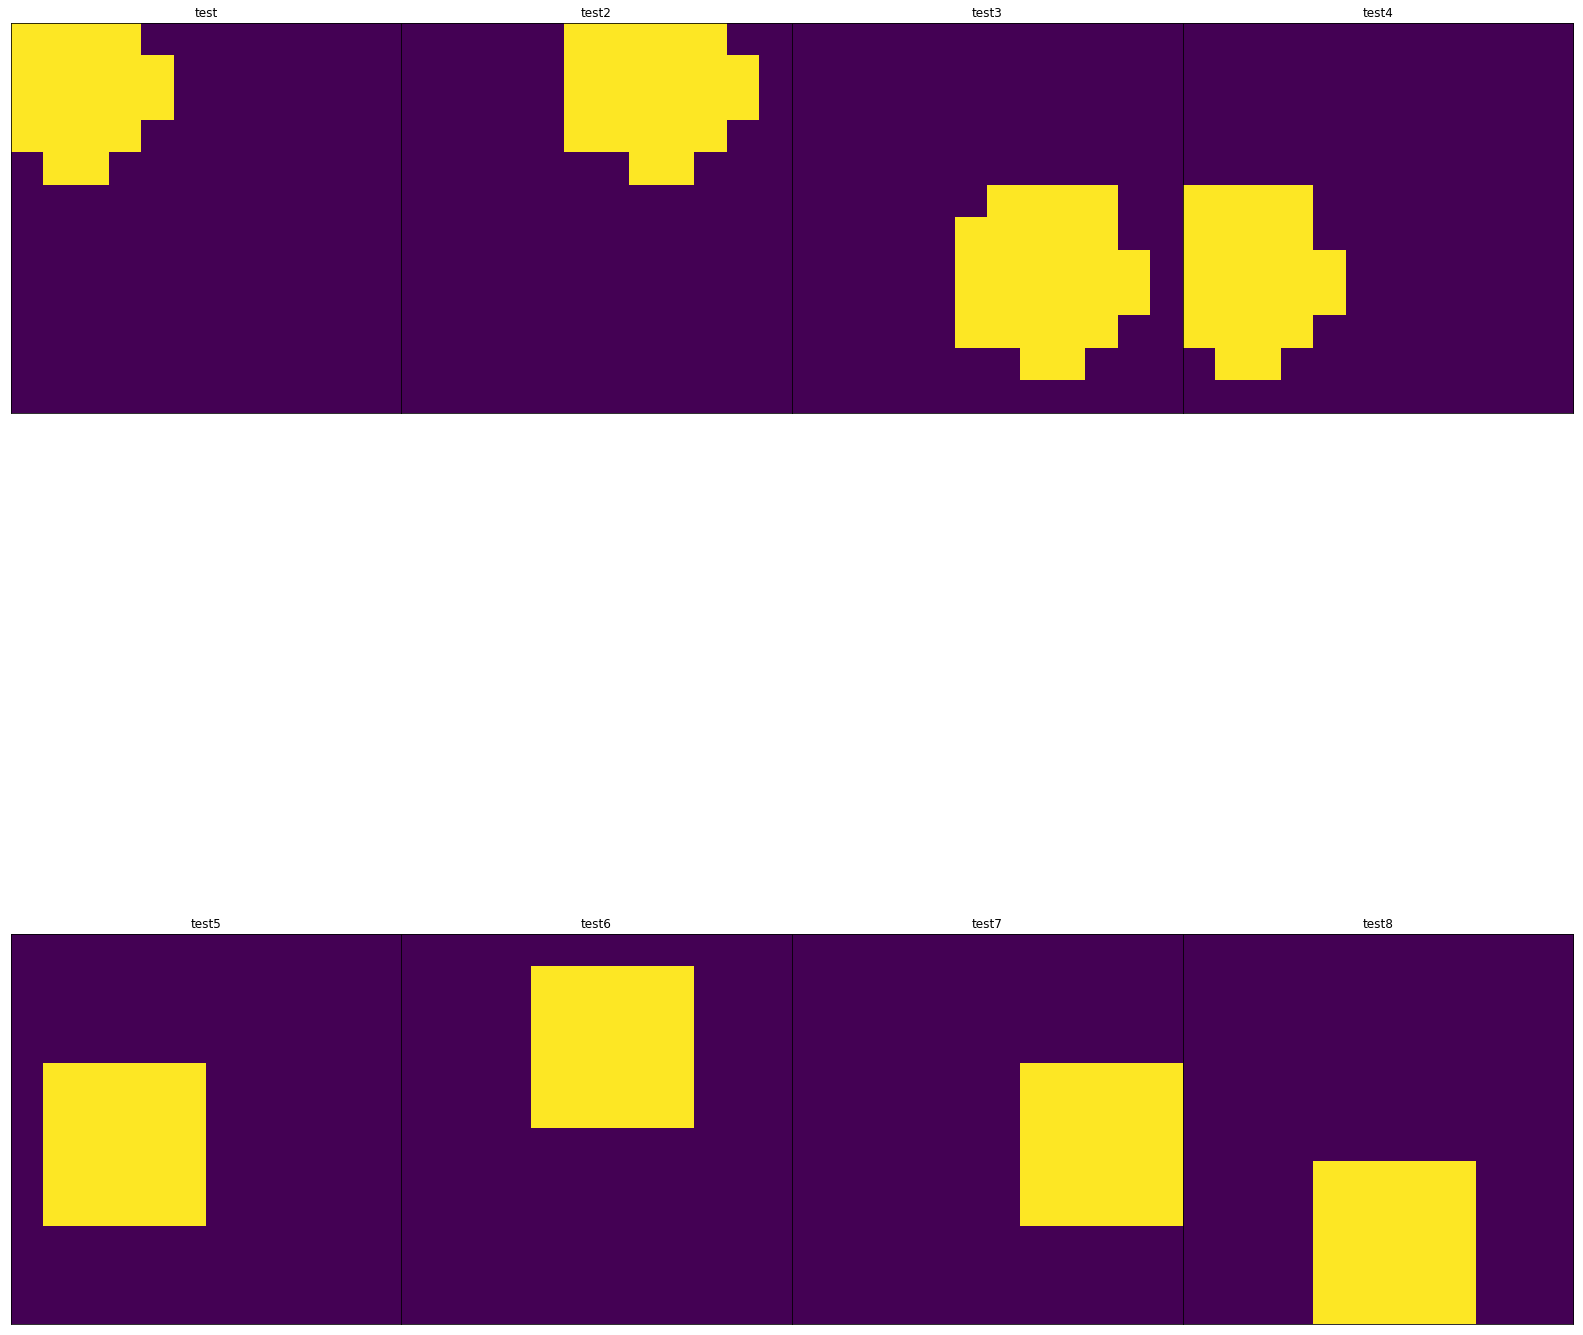

In [37]:

plt.figure(num=None, figsize=(28,32), facecolor='w', edgecolor='k')
ax = [plt.subplot(2,4,i+1) for i in range(8)]
for a in ax:
    a.set_xticklabels([])
    a.set_yticklabels([])
    a.tick_params(bottom=False, left=False)
plt.subplots_adjust(wspace=0,hspace=0.1)


ax[0].title.set_text("test")
ax[0].imshow(createOpposingMask(3, 3, 0))
ax[1].title.set_text("test2")
ax[1].imshow(createOpposingMask(3, 3, 1))
ax[2].title.set_text("test3")
ax[2].imshow(createOpposingMask(3, 3, 2))
ax[3].title.set_text("test4")
ax[3].imshow(createOpposingMask(3, 3, 3))
ax[4].title.set_text("test5")
ax[4].imshow(createOpposingMask(3, 3, 4))
ax[5].title.set_text("test6")
ax[5].imshow(createOpposingMask(3, 3, 5))
ax[6].title.set_text("test7")
ax[6].imshow(createOpposingMask(3, 3, 6))
ax[7].title.set_text("test8")
ax[7].imshow(createOpposingMask(3, 3, 7))

In [15]:
skyViewArr = np.asarray(Image.open("../cropped_data/croppedImage_Skyview200x200.tif"))
skyViewArr.shape

(200, 200)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
8688


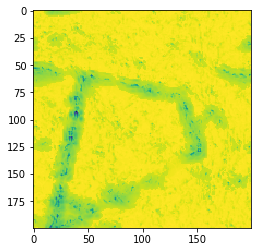

In [96]:
newSkyViewArr = OpposingCircleFilter(skyViewArr, 3, 3, 0.9875)
plt.imshow(newSkyViewArr)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
4871
0.9964563
0.9960848
0.99561256
0.99515975
0.9950358
0.9945345
0.96458197
0.9607866
0.9572765
0.95513546
0.95319617
0.9514632
0.94984245
0.9485059
0.9474411
0.94626117
0.94474953
0.94302493
0.9410133
0.9389399
0.93716246
0.9357694
0.93475634
0.934174
0.93404603
0.9344782
0.935473
0.9367871
0.93830884
0.93

0.9939004
0.9938661
0.9936415
0.99285114
0.99230844
0.9917018
0.99062693
0.98986316
0.98976207
0.98908544
0.9880579
0.9880287
0.9886106
0.98988545
0.9907947
0.9913999
0.9918806
0.9919814
0.9922559
0.9924515
0.99242246
0.99204093
0.99135125
0.99060017
0.9907162
0.9912977
0.9917904
0.9924986
0.99285954
0.9931668
0.9934203
0.993986
0.9951523
0.9958897
0.99575984
0.9954901
0.9947927
0.9942202
0.9944762
0.99495775
0.9951534
0.9952361
0.99523157
0.99536544
0.9957053
0.99578804
0.9959629
0.99591726
0.99581856
0.9959657
0.9959713
0.9958184
0.9957413
0.9955668
0.9953365
0.9952379
0.9952427
0.9952441
0.9953171
0.99537766
0.99545324
0.9955707
0.9957757
0.99594516
0.99584144
0.99570686
0.9954811
0.99506426
0.9942927
0.9934572
0.99248284
0.991625
0.9909616
0.99057937
0.99055314
0.9910192
0.9909243
0.99057776
0.99087626
0.9910872
0.99144953
0.992049
0.9923842
0.9931025
0.9938448
0.9943272
0.9942098
0.99343127
0.99291486
0.9926517
0.99224937
0.9920565
0.9918267
0.99157447
0.9915043
0.9920077
0.992797

0.9946982
0.99423814
0.9940139
0.993738
0.9932395
0.99322647
0.9935286
0.99401563
0.99471676
0.99484515
0.99499136
0.9950109
0.9951004
0.99550885
0.9956705
0.9954047
0.99505675
0.9945033
0.99385154
0.9932937
0.9927199
0.9923972
0.9926737
0.99237967
0.9916758
0.9920642
0.99255466
0.99269754
0.9925639
0.9924702
0.99168354
0.99151564
0.99163604
0.99224436
0.9923122
0.9921524
0.99200094
0.9924309
0.9931567
0.99397737
0.9945314
0.9953006
0.9959407
0.99627477
0.996338
0.9964596
0.99661684
0.9967057
0.996721
0.9964146
0.9959544
0.9957377
0.99574184
0.9959312
0.99593455
0.99581194
0.9957177
0.99557984
0.9954044
0.9958839
0.9960147
0.995934
0.9957937
0.99559563
0.9954344
0.995715
0.9954138
0.9939535
0.992869
0.991608
0.99020743
0.98886365
0.9874404
0.9860366
0.9849923
0.985838
0.98626596
0.98675233
0.98663497
0.98689216
0.987467
0.987893
0.987792
0.98754793
0.9867193
0.98526716
0.98409396
0.98326594
0.9823761
0.98141444
0.98034877
0.97917265
0.9778238
0.9773727
0.9774235
0.977281
0.97752273
0.9

0.98592794
0.98625535
0.98649454
0.987098
0.9872638
0.9870999
0.98620033
0.9854692
0.98440844
0.9828514
0.9818273
0.9808342
0.98071307
0.9813931
0.9817242
0.9822566
0.98305047
0.9840975
0.985088
0.98544663
0.9861382
0.9864462
0.98738724
0.988004
0.9887821
0.9889835
0.9891863
0.989793
0.9904441
0.9912777
0.9919834
0.99194115
0.99256593
0.99277693
0.9924964
0.99223477
0.99158555
0.9911199
0.9902817
0.98952967
0.98866814
0.9877754
0.9861471
0.9841117
0.98228467
0.9812931
0.98036593
0.98024315
0.9797471
0.9803608
0.9813754
0.9830005
0.9845568
0.9858353
0.9876045
0.98985356
0.9915226
0.9931912
0.9936464
0.9939362
0.9943462
0.99479187
0.9949935
0.9949953
0.9947595
0.9946805
0.9945326
0.99407935
0.9940786
0.99424875
0.99435544
0.99482554
0.9953322
0.9954539
0.9958912
0.9962856
0.9965247
0.9967033
0.99688023
0.99692714
0.9967895
0.9965545
0.9964209
0.9960962
0.9959843
0.9956118
0.9951065
0.9950703
0.99506617
0.99520755
0.9954271
0.9950824
0.99500877
0.9949172
0.99466246
0.9940219
0.99319035
0.

0.99419767
0.9939808
0.9939383
0.99388075
0.99410635
0.9942326
0.9946261
0.99502486
0.9951365
0.99540406
0.99557644
0.99558794
0.9956926
0.9957536
0.9955663
0.99498343
0.994484
0.9943719
0.9936972
0.9921126
0.9902577
0.9883839
0.9865898
0.98520166
0.98328906
0.9808609
0.97877115
0.9774025
0.9763747
0.97679347
0.97637403
0.9776967
0.9791191
0.98139614
0.98339206
0.98519504
0.9870728
0.9889439
0.99016297
0.9916053
0.9909263
0.9898401
0.98962486
0.98921984
0.98955375
0.9894801
0.9887184
0.9883938
0.9885467
0.9887646
0.9897035
0.9899266
0.99008095
0.9901404
0.99083084
0.99180764
0.99277276
0.99336946
0.9942987
0.99460876
0.9948786
0.9948513
0.9949193
0.9950328
0.99461997
0.99409175
0.99373007
0.9934232
0.992691
0.9918962
0.99148524
0.990768
0.9902613
0.99025345
0.9893578
0.9895808
0.9607461
0.9595692
0.95532703
0.95595336
0.9567491
0.9575797
0.95844954
0.9594377
0.95975685
0.9603538
0.96105725
0.96183705
0.9627337
0.96351254
0.96388894
0.9643854
0.9648603
0.98063517
0.9820761
0.98356724
0.

0.96054953
0.96146655
0.9622599
0.9628749
0.96313494
0.96313715
0.9630109
0.96275896
0.9624676
0.9622425
0.9617984
0.9609129
0.9597972
0.9587177
0.9578214
0.9571127
0.9557734
0.9530833
0.95101446
0.9496675
0.94741994
0.94418496
0.9433673
0.94258106
0.94273347
0.9408357
0.9391542
0.94159245
0.9452355
0.94723254
0.94930845
0.9504528
0.9510317
0.95228386
0.9530666
0.9540605
0.9551053
0.9560562
0.9571223
0.9585131
0.9604553
0.96273285
0.96505225
0.97229755
0.97292036
0.97395784
0.97525793
0.9768942
0.9792346
0.98143405
0.9828932
0.98457146
0.9852997
0.98597664
0.9861365
0.98611873
0.98569703
0.9850273
0.98448706
0.9844211
0.9844936
0.9854499
0.9860201
0.98695076
0.9875003
0.987993
0.98817843
0.98810524
0.9873116
0.9867084
0.9651362
0.964649
0.96448416
0.9646472
0.9650863
0.98841906
0.9889494
0.9902125
0.9918418
0.99279237
0.9936906
0.99360746
0.99353856
0.9935127
0.9934972
0.9933758
0.99354804
0.9937908
0.9937034
0.99437565
0.9945152
0.9947442
0.99471205
0.9947524
0.9952153
0.9951705
0.995

0.96463424
0.977063
0.97755724
0.9780093
0.9777198
0.9772827
0.9768726
0.97659355
0.97616905
0.9762167
0.97521573
0.9741842
0.97451377
0.9738213
0.9738318
0.97446716
0.97506976
0.97613275
0.9772653
0.9795122
0.9819828
0.9835887
0.9857486
0.9874826
0.9888602
0.990783
0.99220854
0.99227273
0.992546
0.9928915
0.993102
0.9920393
0.9909898
0.990477
0.9901166
0.9893896
0.9878632
0.9862574
0.9850035
0.9848797
0.98557204
0.98662186
0.9871252
0.9878926
0.9886358
0.99101317
0.9933069
0.9949635
0.9952467
0.9953564
0.99502367
0.99483705
0.9947601
0.9946359
0.99443
0.9939727
0.99334425
0.9931173
0.99329996
0.9929987
0.99218386
0.9907611
0.9894796
0.988203
0.9870761
0.9859709
0.98497653
0.9841297
0.9838814
0.984173
0.98438966
0.9849084
0.98597586
0.9873995
0.98834276
0.9888411
0.9899225
0.98722786
0.9873108
0.98731947
0.9876944
0.9883045
0.9890171
0.9898176
0.9905427
0.9911068
0.9913687
0.99208814
0.99251395
0.9929488
0.9935535
0.9936594
0.99393296
0.99425
0.99435616
0.9946551
0.9948116
0.9949221
0.

0.9918439
0.9925044
0.99242544
0.99174565
0.99051636
0.98880184
0.9864863
0.9629765
0.9603708
0.9580885
0.95630294
0.9547791
0.95345813
0.94833994
0.9405924
0.93402684
0.92935556
0.92651534
0.92509764
0.92513096
0.92679924
0.93088174
0.9369626
0.9440047
0.9470567
0.94926256
0.9520937
0.9554959
0.95927626
0.96321845
0.988595
0.98948616
0.9884111
0.9884072
0.98850685
0.98905206
0.9897278
0.9903329
0.9908111
0.9920332
0.9927531
0.9936959
0.9942635
0.9940432
0.99366575
0.99320036
0.99312097
0.99290395
0.99279964
0.9926611
0.99277073
0.9925183
0.9926516
0.99323523
0.99403745
0.9948709
0.9959021
0.9963337
0.99652773
0.99630266
0.9959019
0.99528676
0.99444705
0.9939721
0.993483
0.99330926
0.99327576
0.99334866
0.9934834
0.99359614
0.9938834
0.99461025
0.99494356
0.99479145
0.9946486
0.9944364
0.9943361
0.9940898
0.9938523
0.9932949
0.9927982
0.9924291
0.9925341
0.9924154
0.9919657
0.99145573
0.99085325
0.990527
0.9904293
0.99042326
0.9904945
0.99020255
0.9901012
0.9900889
0.99026453
0.9903101

0.9969785
0.9968051
0.9963188
0.99595624
0.99550956
0.9948028
0.9944512
0.99331146
0.99079907
0.9876832
0.9840913
0.96440405
0.96194947
0.9599924
0.9585682
0.95542806
0.95141715
0.9484121
0.94631153
0.9449865
0.9443607
0.9446677
0.9454575
0.9457978
0.9469165
0.9486287
0.95086056
0.9535323
0.9565374
0.95924866
0.9600555
0.96093637
0.9612331
0.96058
0.95998156
0.9594266
0.9590514
0.9589005
0.9589688
0.95935
0.9600356
0.960963
0.96080273
0.9605788
0.9591646
0.95827323
0.9580215
0.958443
0.9595129
0.9610666
0.96306664
0.97234166
0.975445
0.9787231
0.98205525
0.98452497
0.98721784
0.9899185
0.992234
0.9936776
0.9947931
0.99483496
0.9951433
0.9953873
0.9955138
0.99566925
0.99580234
0.99591655
0.99599206
0.99564683
0.9956248
0.995911
0.99624425
0.99656695
0.9967377
0.99686694
0.9969325
0.9968185
0.99410456
0.9945382
0.99485934
0.99448216
0.9941299
0.9938558
0.9938697
0.9938897
0.9937084
0.9934569
0.9928087
0.9921047
0.9916717
0.99129856
0.9902902
0.9892809
0.98865587
0.98815304
0.98761934
0.9

0.9906062
0.9914156
0.9910138
0.9627354
0.95962256
0.9570595
0.95452696
0.950359
0.9468138
0.94399047
0.94210696
0.9377048
0.93369395
0.9301295
0.9279165
0.9270537
0.9274467
0.9292975
0.9317012
0.932876
0.93520397
0.93849766
0.94265175
0.9475979
0.9530837
0.9585306
0.9636045
0.9890038
0.9919531
0.994079
0.99509966
0.99521804
0.9950453
0.994744
0.99434024
0.9940437
0.9935108
0.99305564
0.99295586
0.9927785
0.9926944
0.9927759
0.9926396
0.9924439
0.9925794
0.99230653
0.99156445
0.9913679
0.9913428
0.98994243
0.98887014
0.98785263
0.98718524
0.9874342
0.9879629
0.9873589
0.98653984
0.9862747
0.98677087
0.9877058
0.9884386
0.9886134
0.9887367
0.9882657
0.9871327
0.9858184
0.9854122
0.98494107
0.9837466
0.98357534
0.9841096
0.9847325
0.9866078
0.9889231
0.9908223
0.9921337
0.9933853
0.9949179
0.99621034
0.99686015
0.9969594
0.99682915
0.99604976
0.99514693
0.9938819
0.992969
0.99183863
0.99115163
0.99043447
0.99016047
0.9897515
0.990443
0.9909644
0.9917425
0.99260557
0.9931964
0.99352443
0.

0.98643106
0.9874652
0.98831564
0.9888856
0.99011433
0.991459
0.99250424
0.99348915
0.99431
0.994729
0.99460185
0.9940495
0.9935965
0.9931501
0.99153215
0.9894882
0.98666275
0.9842212
0.9822751
0.9646759
0.96099585
0.95718807
0.95338196
0.9498845
0.946692
0.943649
0.9406679
0.93802947
0.9362153
0.93574816
0.93632704
0.93774873
0.9396374
0.94225633
0.946005
0.9509999
0.9541626
0.9560351
0.9582283
0.96072423
0.96361125
0.9880292
0.98986876
0.99114877
0.9915046
0.9917948
0.9920524
0.99207294
0.9920548
0.9920025
0.9919075
0.99199015
0.991105
0.9903341
0.98965085
0.9888189
0.98790544
0.98654866
0.9847738
0.9832762
0.98234904
0.98246384
0.98196286
0.98070943
0.9789998
0.97870386
0.9790832
0.98149025
0.9827151
0.9832093
0.98407227
0.98442686
0.9842119
0.9838554
0.98290205
0.981498
0.9794517
0.97888184
0.9786458
0.9768934
0.9764583
0.975611
0.9742802
0.97344387
0.9727503
0.97110975
0.96959174
0.9694344
0.96897155
0.96899706
0.96940756
0.9707189
0.9730136
0.97632235
0.9788776
0.9813411
0.984016

0.9904383
0.9906738
0.9910818
0.99149084
0.9915303
0.9912932
0.9910947
0.9909862
0.99038374
0.9894379
0.9882738
0.9869841
0.9853438
0.983567
0.98193836
0.97998834
0.9778166
0.9753503
0.96444887
0.96227753
0.9600757
0.9578873
0.95582443
0.95392
0.95233727
0.95117295
0.95055884
0.95053285
0.95104575
0.9520492
0.95217633
0.95232105
0.95305485
0.9534166
0.95344174
0.95395106
0.95493907
0.956327
0.958017
0.9600692
0.9624386
0.9651646
0.991522
0.9923165
0.99271584
0.9929643
0.9932198
0.9931972
0.99345946
0.99370795
0.9930002
0.9915023
0.9903618
0.98871696
0.98859054
0.98886937
0.98815215
0.98781216
0.9884374
0.9890691
0.9906583
0.9919309
0.9930135
0.9925688
0.99246407
0.99267983
0.99277854
0.99274397
0.99283427
0.99316984
0.9936354
0.9941186
0.99444515
0.9948953
0.99517024
0.9952942
0.99513096
0.9950876
0.9950779
0.99479306
0.9952928
0.9952113
0.9949762
0.99489075
0.99500793
0.9951767
0.9949928
0.99460673
0.994493
0.99439853
0.9942741
0.9943404
0.99397266
0.9936421
0.9931801
0.99181265
0.989

0.9571186
0.95503145
0.95319355
0.9519295
0.94786674
0.9449462
0.94120777
0.93905085
0.93817794
0.93844527
0.9389854
0.9418077
0.94644856
0.95131075
0.95532995
0.95691276
0.9586828
0.9600613
0.9619361
0.9644925
0.99047774
0.99315566
0.9939382
0.99378264
0.9936245
0.99402237
0.9943859
0.99438375
0.9943366
0.9940253
0.9935521
0.9928088
0.9923773
0.99221385
0.9919854
0.991936
0.9919154
0.9920899
0.99272627
0.9936807
0.99458426
0.99486303
0.9942459
0.99402505
0.9941276
0.994281
0.99366
0.99256307
0.9910241
0.98961985
0.989084
0.98865414
0.9885622
0.9885418
0.9883853
0.98886615
0.98962706
0.9902801
0.9912272
0.99159956
0.9920359
0.9924417
0.99223727
0.99186563
0.9914273
0.99155945
0.991733
0.9920757
0.99235475
0.9923606
0.99212545
0.9924899
0.9928684
0.99343634
0.9935236
0.9935669
0.99331725
0.9933002
0.993139
0.99251556
0.9911029
0.98941416
0.98788387
0.9871361
0.98605865
0.98480004
0.9834741
0.9823835
0.98195606
0.9815321
0.9807809
0.9805425
0.9809436
0.98113805
0.9811233
0.9812294
0.9809

0.9845452
0.9864673
0.98745245
0.9894306
0.99116474
0.99255764
0.9929747
0.99300265
0.99319184
0.9933544
0.9935336
0.99338573
0.99304646
0.9928748
0.9925931
0.9928914
0.99342686
0.9931628
0.99270433
0.9924688
0.9925641
0.9928666
0.99313253
0.9936724
0.99394333
0.9941928
0.9944635
0.99415743
0.9938106
0.99305254
0.99249935
0.9922669
0.99113536
0.98987406
0.9894878
0.9888763
0.98762625
0.9858803
0.98506635
0.9835332
0.98312294
0.98401463
0.98344177
0.98245484
0.9830699
0.9840457
0.98616314
0.987966
0.9896922
0.99030644
0.9906123
0.9909123
0.9914446
0.9907028
0.98959434
0.9874764
0.9844674
0.98193204
0.9801531
0.9791303
0.9786147
0.978437
0.97783726
0.9778683
0.9789588
0.98033696
0.98041904
0.9810051
0.98124135
0.98062116
0.9799253
0.9807967
0.9814232
0.98331267
0.98458654
0.98611134
0.987614
0.98844504
0.9902498
0.9918632
0.9932994
0.9925033
0.99259806
0.99263066
0.99302655
0.9941769
0.99518925
0.9956578
0.9958051
0.9959465
0.99625975
0.9964082
0.9965319
0.996559
0.9952524
0.99259424
0.9

0.9258739
0.92007446
0.9159659
0.9129038
0.91217154
0.91098547
0.91414315
0.919876
0.9254497
0.9283052
0.9279514
0.928429
0.92976594
0.93197757
0.93359345
0.9358947
0.9385648
0.9414984
0.9445708
0.94754153
0.95034546
0.95283926
0.9548858
0.9557341
0.9565504
0.95737064
0.958324
0.95947874
0.9607587
0.96207285
0.9626232
0.9621813
0.96164906
0.96133316
0.96140265
0.96172565
0.9621706
0.96268994
0.96122104
0.9598433
0.9586419
0.9576247
0.9568079
0.95616823
0.9556807
0.9552883
0.95489234
0.9543894
0.9537497
0.952981
0.9514006
0.9498941
0.94871515
0.94797975
0.9475262
0.94722754
0.94675624
0.9460501
0.9450481
0.9447466
0.9452706
0.94668746
0.9471941
0.94788855
0.94883025
0.9501418
0.95178723
0.9533832
0.9543457
0.95554733
0.957068
0.958891
0.96089244
0.9630806
0.9780418
0.98111403
0.9833192
0.9856694
0.9880166
0.9900938
0.99116147
0.99119836
0.9904999
0.9902235
0.9899917
0.98986554
0.98991114
0.99000984
0.9901399
0.9906478
0.9919888
0.99340963
0.99449444
0.9951582
0.995544
0.9956765
0.995942

0.93012124
0.92682874
0.9244932
0.9231411
0.92259496
0.92287105
0.92396337
0.92603946
0.92877746
0.93201566
0.9341779
0.9349735
0.9362569
0.93790704
0.93976486
0.940757
0.940964
0.9409713
0.9409553
0.9410501
0.94134945
0.94173723
0.94203484
0.9423095
0.9425262
0.94259
0.9423822
0.9419608
0.9414167
0.94082195
0.94040877
0.9404582
0.9410456
0.9420707
0.94356394
0.9456594
0.94830287
0.951413
0.95451033
0.9540344
0.9538772
0.9541382
0.95478004
0.9557671
0.957195
0.95900834
0.96117634
0.9634922
0.9887122
0.98984295
0.9906513
0.9904131
0.98993707
0.99017113
0.99020743
0.990206
0.98988533
0.9893689
0.9892176
0.98956186
0.99017113
0.9911092
0.99178714
0.99277925
0.99309635
0.9934405
0.99480164
0.99534273
0.9956143
0.99591917
0.99590635
0.99595547
0.9961117
0.99613637
0.996262
0.9963178
0.9964516
0.99650455
0.99640185
0.99609923
0.9955013
0.99514323
0.99533236
0.99542576
0.99524224
0.9953092
0.9949405
0.9944969
0.9943463
0.994476
0.99454015
0.99405223
0.9934133
0.992825
0.99119985
0.9905966
0.9

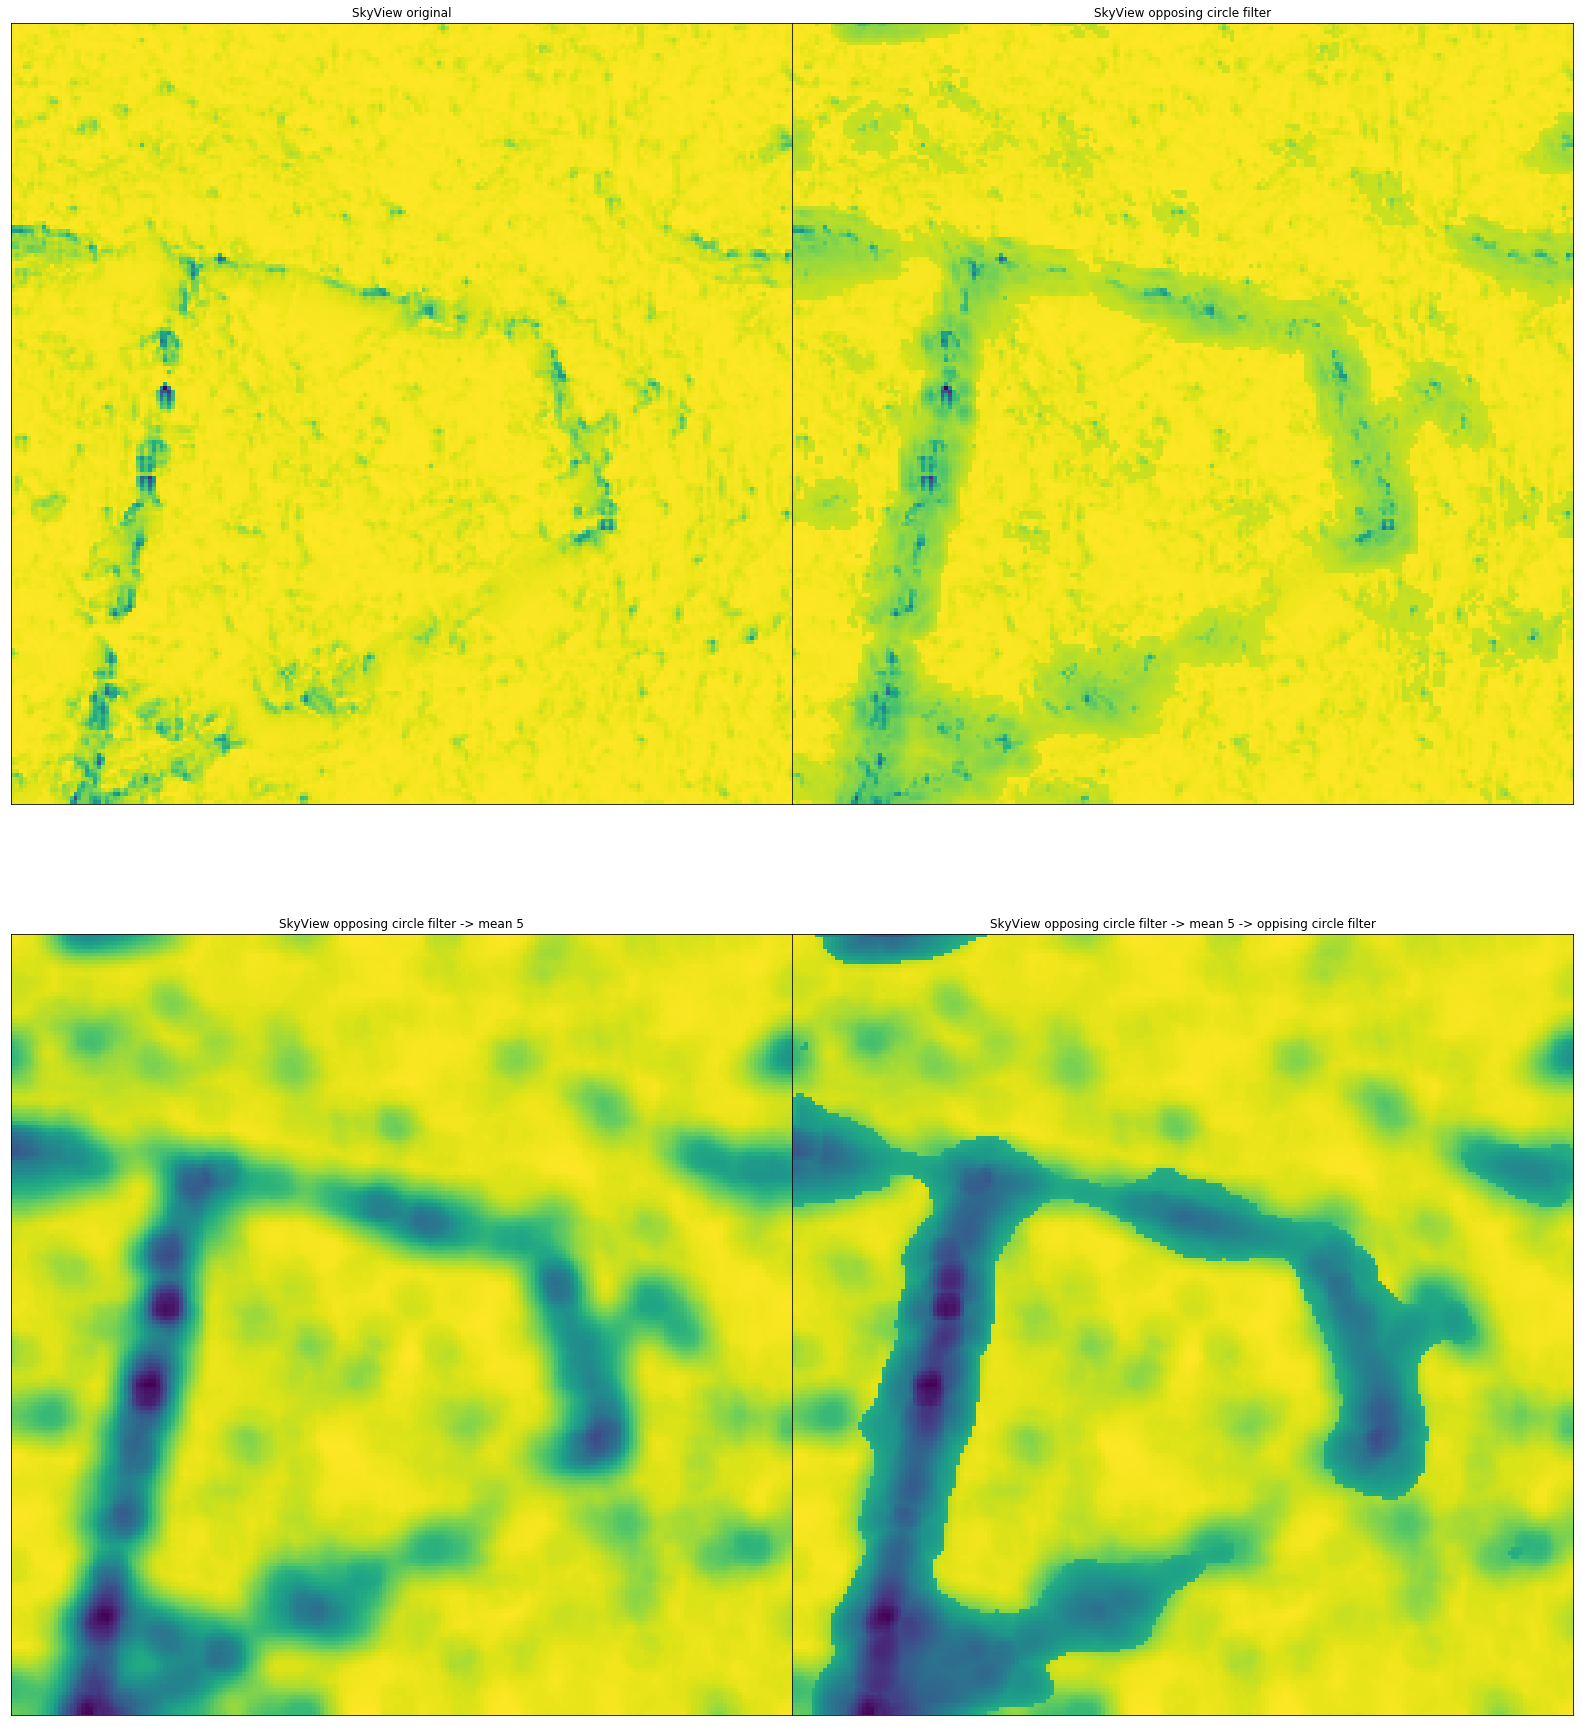

In [99]:
plt.figure(num=None, figsize=(28,32), facecolor='w', edgecolor='k')
ax = [plt.subplot(2,2,i+1) for i in range(4)]
for a in ax:
    a.set_xticklabels([])
    a.set_yticklabels([])
    a.tick_params(bottom=False, left=False)
plt.subplots_adjust(wspace=0,hspace=0.1)

mean = gf(newSkyViewArr, np.nanmean, footprint=create_circular_mask(5))

newNewSkyViewArr = OpposingCircleFilter(mean, 3, 6, 0.975)

for row in newNewSkyViewArr:
    for pixel in row:
        print(pixel)

ax[0].title.set_text("SkyView original")
ax[0].imshow(skyViewArr)
ax[1].title.set_text("SkyView opposing circle filter")
ax[1].imshow(newSkyViewArr)
ax[2].title.set_text("SkyView opposing circle filter -> mean 5")
ax[2].imshow(mean)
ax[3].title.set_text("SkyView opposing circle filter -> mean 5 -> oppising circle filter")
ax[3].imshow(newNewSkyViewArr)

In [100]:
impoundmentArr = np.asarray(Image.open("../cropped_data/croppedImage_Impoundment200x200.tif"))
impoundmentArr.shape

(200, 200)

In [102]:
np.amax(impoundmentArr)

1.0677643

In [103]:
np.amin(impoundmentArr)

0.0

In [106]:
for row in impoundmentArr:
    for pixel in row:
        if pixel < 0.01:
            print(pixel)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0034179688
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0034942627
0.0
0.0
0.006286621
0.0
0.009719849
0.004760742
0.0010528564
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0077819824
0.008117676
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0030975342
0.0
0.0
0.0
0.0
0.00440979
0.0068511963
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0011901855
0.0
0.0
0.0
0.0
0.008987427
0.0057678223
0.0
0.0
0.009613037
0.0
0.0
0.0
0.004196167
0.0
0.0
0.0
0.0
0.008300781
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.001663208
0.0012664795
0.00091552734
0.0
0.0
0.007965088
0.0
0.009033203
0.0
0.007843018
0.006134033
0.0
0.0
0.0
0.0
0.008102417
0.0
0.0
0.0
0.0
0.0017700195
0.0
0.0
0.007232666
0.0
0.008956909
0.0009460449
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0014953613
0.0
0.007797241
0.0
0.002532959
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0054016113
0.0
0.0
0.0
0.0
0.0
0.0012054443
0.0
0.0
0.009735107
0.0
0.0029754639
0.0
0.0
0.0
0.0
0.0
0.0041046143
0.000869751
0.0
0.0
0.0
0.0
0.0
0.0
0.0

0.0017700195
0.0067596436
0.0
0.0
0.009185791
0.0
0.0
0.0
0.0
0.0049743652
0.0
0.0037841797
0.0
0.0050201416
0.0
0.0
0.0
0.00079345703
0.0
0.0
0.0
0.0
0.0
0.007843018
0.0007171631
0.0
0.0
0.0
0.008163452
0.0
0.0
0.0
0.0
0.0
0.0
0.009246826
0.0
0.0
0.0
0.0
0.007171631
0.0
0.0
0.0023345947
0.0
0.0
0.0
0.0
0.0018615723
0.0
0.0
0.0
0.0
0.0
0.0
0.00061035156
0.0
0.00064086914
0.009811401
0.0
0.005050659
0.0
0.0
0.0
0.0
0.009796143
0.0
0.009994507
0.009963989
0.0
0.0
0.0
0.0
0.0047912598
0.0031280518
0.0
0.0022125244
0.0
0.00390625
0.0
0.0037231445
0.0
0.0
0.0
0.005203247
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.001373291
0.0
0.0
0.0
0.003112793
0.0
0.0077667236
0.0
0.0
0.0
0.0
0.0
0.0
0.0021972656
0.0
0.0
0.0
0.0069122314
1.5258789e-05
0.009475708
0.0
0.0
6.1035156e-05
0.0013427734
0.0
0.0
0.0059661865
0.0
0.0
0.0061035156
0.0014343262
0.0
0.0
0.0
0.0
0.0
0.0
0.0084991455
0.0
0.0043182373
0.0
0.0
0.0039367676
0.0038452148
0.0
0.0
0.0
0.0070495605
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0068969727
0.00724792

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.00032043457
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.00044250488
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.004470825
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0077209473
0.0
0.0
0.0057373047
0.0047912598
0.0
0.0
0.0
0.0013275146
0.005050659
0.008178711
0.0071868896
0.007247925
0.0
0.006576538
0.0032196045
0.0
0.0
0.0
0.0
0.006942749
0.0019073486
0.0
0.0
0.0
0.0
0.0073394775
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.006286621
0.0
0.0
0.0
0.00019836426
0.0
0.0
0.0048217773
0.0
0.0
0.0031280518
0.0062561035
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.004196167
0.0
0.0
0.0
0.0
0.0
0.0
0.009567261
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0048828125
0.004348755
0.0
0.0
0.0055236816
0.0069732666
0.0
0.0
0.008422852
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.008483887
0.0075683594
0.0073547363
0.0029449463
0.0
0.0
0.0
0.0
0.0
0.0027923584
0.0
0.0
0.0
0.0
0.0
0.0
0.0069732666
0.0
0.0
0.006378174
0.0
0.0011444092
0.0
0.0
0.0
0.008071899
0.002166748
0.0
0.

0.0
0.0
0.0059814453
0.0
0.0
0.0
0.0065612793
0.0
0.0
0.0
0.0
0.0076293945
0.0
0.0
0.0
0.0
0.005706787
0.0061950684
0.0
0.0
0.009994507
0.0
0.0
0.00491333
0.0
0.0
0.0
0.0011291504
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.004135132
0.0
0.009780884
0.0
0.0
0.0
0.0
0.0
0.0
0.0047912598
0.0
0.0025482178
0.0
0.005554199
0.00021362305
0.0
0.0
0.0
0.0
0.0
0.004486084
0.0
0.0
0.0
0.007797241
0.007904053
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.006500244
0.0
0.0
0.0
0.0
0.0
0.0062561035
0.0
0.0026245117
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0056915283
0.0031433105
0.0
0.0
0.0
0.0
0.0034179688
0.0
0.0
0.0
0.0
0.0
0.0
0.0014801025
0.0042419434
0.0
0.0069274902
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.005554199
0.0
0.0
0.00440979
0.0
0.0
0.0
0.007537842
0.0073394775
0.00970459
0.0
0.0
0.0
0.0
0.0
0.0
0.005645752
0.0029144287
0.0
0.0073547363
0.008575439
0.0
0.0
0.0
0.002166748
0.0
0.0071411133
0.007797241
0.0
0.0
0.0
0.0
0.0068359375
0.0
0.0
0.005203247
0.0
0.005844116
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.008163452
0.0056762695


0.0
0.004928589
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0044555664
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.00970459
0.0
0.0
0.009933472
0.009994507
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.004486084
0.0
0.0
0.0
0.0018157959
0.0021514893
0.0
0.0077056885
0.0
0.0
0.0
0.003036499
0.0
0.0
0.0060272217
0.0
0.0
0.0
0.0018310547
0.004043579
0.0
0.0045928955
0.0
0.002456665
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0051574707
0.009643555
0.0
0.0
0.0070495605
0.00541687
0.007843018
0.0
0.0
0.0
0.0
0.008590698
0.0
0.005935669
0.0016937256
0.0071105957
0.0
0.0
0.0
0.0059051514
0.0
0.0
0.0
0.0
0.0
0.0
0.008682251
0.0032043457
0.0032806396
0.0
0.0
0.0
0.0
3.0517578e-05
0.0
0.0
0.008041382
0.0
0.0
0.0
0.0
0.0
0.0
0.0067596436
0.0013427734
0.0
0.0
0.0029449463
0.0
0.0
0.0
0.002746582
0.0
0.0
0.003036499
0.0
0.0
0.0055236816
0.006072998
0.0065307617
0.0
0.0
0.0
0.0020599365
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.00039672852
0.001953125
0.00920105
0.001953125
0.009765625
0.0
0.00088500977
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.001449585
0.0
0.0
0.009307861
0.0
0.0007324219
0.0
0.0
0.0045318604
0.008361816
0.0010070801
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
3.0517578e-05
0.0
0.0
0.0
0.0
0.0
0.00018310547
0.0
0.0
0.0
0.0058898926
0.0055389404
0.00018310547
0.0027923584
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0076904297
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0063323975
0.0
0.0
0.0
0.0
0.0039978027
0.004425049
0.0
0.0
0.009155273
0.0
0.0
0.0071105957
0.0
0.0
0.0040893555
0.004486084
0.0
0.0
0.0
0.008529663
0.0074768066
0.0
0.0
0.0
0.0
0.0
0.002670288
0.0
0.0
0.0
0.0
0.0
0.009933472
0.003982544
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.005065918
0.007522583
0.0
0.0
0.0025177002
0.0005645752
0.008773804
0.0014648438
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.004760742
0.006210327
0.005355835
0.008071899
0.0
0.0
0.004760742
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0010375977
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0036010742
0.008865356
0.008850098
0.000579834
0

0.0041046143
0.009109497
0.0008544922
0.0
0.0
0.009063721
0.0026397705
0.0
0.0
0.0
0.0
0.0
0.0049591064
0.0011138916
0.0
0.0
0.0012817383
0.0
0.0
0.008056641
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0005950928
0.0
0.0
0.009979248
0.0
0.0
0.0
0.0022125244
0.0
0.0
0.009338379
0.0030517578
0.0
0.0037231445
0.0
0.0
0.0018005371
0.0
0.0
0.0
0.0
0.0
0.00340271
0.004623413
0.0
0.0
0.0
0.0
0.0
0.00642395
0.0
0.0
0.0
0.004257202
0.004196167
0.0
0.0
0.0056762695
0.0008392334
0.0
0.0
0.0
0.0
0.0019989014
0.0
0.0
0.0
0.0
0.0
0.0038909912
0.0017547607
0.0
0.0
0.006668091
0.004058838
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.00090026855
0.0
0.0010528564
0.0
0.0056610107
0.0
0.0
0.0
0.0
0.0023651123
0.0
0.0
0.0044555664
0.004058838
0.008483887
0.0
0.0
0.0016784668
0.0
0.0
0.0
0.004776001
1.5258789e-05
0.0018157959
0.0
0.00012207031
0.0
0.0
0.0074157715
0.0
0.0
0.0
0.0
0.0014190674
0.0
0.0
0.0
0.0077819824
0.0
0.0
0.008361816
0.0
0.0
0.0034637451
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.003753662
0.0
0.

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
8065


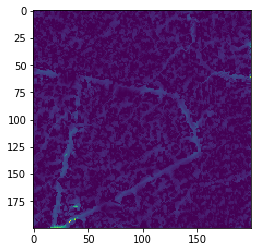

In [112]:
newImpoundmentArr = OpposingCircleFilter(impoundmentArr, 3, 3, 0.2)
plt.imshow(newImpoundmentArr)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
1262
0.047666714
0.04835664
0.04626753
0.046924107
0.046489082
0.04642154
0.048120584
0.04375459
0.039957866
0.034034308
0.029241554
0.02615572
0.026794467
0.028774826
0.032367885
0.03171283
0.031938117
0.031412043
0.032214463
0.03444835
0.035282817
0.031156676
0.026170349
0.019108009
0.016550446
0.015176773


0.03173404
0.03409075
0.034832444
0.020818012
0.01946118
0.019670743
0.017918896
0.016099095
0.016274462
0.016138315
0.016166762
0.01656489
0.01787408
0.01696603
0.017095977
0.01989432
0.021163868
0.01867439
0.016901584
0.014598514
0.01385105
0.012647198
0.013154365
0.012613625
0.012774086
0.015331938
0.017610257
0.017318835
0.018731331
0.020896714
0.022632647
0.023197656
0.02398078
0.023400893
0.022806874
0.025321187
0.027732847
0.027790373
0.02575926
0.024905847
0.024807874
0.023394033
0.021834059
0.022614574
0.022334794
0.02262497
0.020084675
0.02007288
0.022616504
0.022349682
0.022418726
0.02166965
0.020292547
0.018519698
0.016227765
0.016573759
0.015739484
0.0148088895
0.013433882
0.013497101
0.015530464
0.01827048
0.017636478
0.017099397
0.016272752
0.016420811
0.0150001235
0.015497617
0.015188315
0.01647827
0.019114718
0.022254191
0.026721597
0.031822257
0.038439147
0.043365274
0.04823541
0.05221175
0.052425332
0.049167473
0.04439123
0.039131947
0.03354729
0.02821941
0.023890492

0.030910674
0.026491975
0.023906996
0.026055656
0.012548585
0.014015527
0.013398034
0.016771255
0.01950625
0.020785313
0.024356432
0.025112294
0.024556302
0.023031088
0.022182863
0.021903032
0.022948205
0.02314069
0.02307342
0.024818962
0.025258223
0.026679581
0.029124252
0.029754268
0.028730385
0.0297604
0.03168355
0.034646176
0.03670074
0.037472904
0.039485592
0.04330865
0.04554798
0.04684297
0.04748866
0.042780027
0.03731053
0.033991814
0.032610614
0.03286236
0.0355432
0.034978025
0.033812743
0.03277048
0.034797646
0.03498576
0.034210324
0.032289546
0.02959755
0.026324794
0.0272625
0.027295962
0.026720189
0.02328663
0.02064577
0.018462967
0.017875899
0.01850651
0.018701708
0.018077435
0.018105777
0.018531535
0.01922287
0.021139955
0.025241904
0.029033057
0.030096624
0.033300392
0.038795393
0.04123577
0.04363294
0.046476137
0.04455319
0.04355997
0.04167274
0.03971897
0.037247803
0.033210892
0.029246453
0.025862932
0.023432503
0.02500365
0.027399333
0.030529074
0.030964937
0.030028991

0.023454692
0.024874676
0.023311956
0.02244498
0.020336516
0.016958008
0.014256998
0.014115728
0.014452709
0.016232563
0.017159307
0.020881834
0.02582295
0.02972846
0.0323058
0.033717744
0.03285858
0.033788588
0.03329849
0.03228834
0.030085562
0.027365753
0.02220832
0.02026445
0.020452289
0.023800885
0.025007004
0.024871536
0.02560417
0.024666116
0.024187498
0.025617255
0.030063836
0.03501741
0.040369555
0.04408101
0.047669023
0.050329283
0.052004796
0.04951463
0.051212
0.051848777
0.05161753
0.051867846
0.05177636
0.048522305
0.04873508
0.047153845
0.044757254
0.04182798
0.041529037
0.039877474
0.038674064
0.0395766
0.041249525
0.03856003
0.036946546
0.03665877
0.035987675
0.036469817
0.034545362
0.03062633
0.028170582
0.028459454
0.031809803
0.035449553
0.03418522
0.030810349
0.026983835
0.025456106
0.025724843
0.027684553
0.029754926
0.033788227
0.037571687
0.040585775
0.04227982
0.044705994
0.046170294
0.045320176
0.04669023
0.047270883
0.044477522
0.041512884
0.043373052
0.0470471

0.04259523
0.044879913
0.0432954
0.044484723
0.043263417
0.029004041
0.027587341
0.028813018
0.031112174
0.03312759
0.03404925
0.035087563
0.033620518
0.031915672
0.032028973
0.032977358
0.033258464
0.033279363
0.031520694
0.030428855
0.029354105
0.030799422
0.029926373
0.030443758
0.032477155
0.031946037
0.03143946
0.035551667
0.035451964
0.03395635
0.030787969
0.030085264
0.027251674
0.024787638
0.022942405
0.023021271
0.024644123
0.024347894
0.024719331
0.027052723
0.029549168
0.029531483
0.030563248
0.02757687
0.024789786
0.02204365
0.018092103
0.015832387
0.016116828
0.014836083
0.013973289
0.0151858665
0.017000325
0.01575986
0.015961038
0.016003
0.019794315
0.02128491
0.022643475
0.022993475
0.02133426
0.018588109
0.018725874
0.019994706
0.021117402
0.020453041
0.020427039
0.020691289
0.020960812
0.022905216
0.026201876
0.02860681
0.029809289
0.03250177
0.033739492
0.03307545
0.03465507
0.035748094
0.0341803
0.031854574
0.029680599
0.027030017
0.026275093
0.028075732
0.028590102


0.026746135
0.025334882
0.023476781
0.02316459
0.021398064
0.019954195
0.021072265
0.023339527
0.02412342
0.023186227
0.023224464
0.026933065
0.029811481
0.03263746
0.03371769
0.0335329
0.034109343
0.036269944
0.03744064
0.036026914
0.033405654
0.030297603
0.027144223
0.028350601
0.028040875
0.026341554
0.026917001
0.02653204
0.027000591
0.028529167
0.03247191
0.03679942
0.03776896
0.036629114
0.03604803
0.03424974
0.03437704
0.036859766
0.03577844
0.033128243
0.029270004
0.025266666
0.023837911
0.023593433
0.02346583
0.022224538
0.021312224
0.02077078
0.020531368
0.021095846
0.022288313
0.023335624
0.022656493
0.022147434
0.022690877
0.024990175
0.027011152
0.02985916
0.029684965
0.030676603
0.03256723
0.036220834
0.03904005
0.044425048
0.046584744
0.05001041
0.051976703
0.05582626
0.05626801
0.057048194
0.055192422
0.057721447
0.05986756
0.061115902
0.062902294
0.065317266
0.07017659
0.06893325
0.06762862
0.06624102
0.06509151
0.0648413
0.06576179
0.06791313
0.07105939
0.07479147
0.0

0.044329345
0.048603266
0.050027862
0.054342207
0.060626503
0.062093206
0.023631008
0.023789428
0.024386926
0.023452148
0.021897761
0.023323638
0.024930976
0.026416551
0.028658796
0.030185197
0.028266754
0.026698487
0.025526851
0.024993679
0.026692567
0.027813531
0.029769082
0.029191716
0.028104482
0.028467327
0.030186275
0.03334484
0.036632292
0.03477881
0.030460157
0.027569653
0.026245868
0.028069517
0.030641863
0.03135343
0.0292743
0.02619469
0.026546497
0.027670898
0.029292233
0.031923413
0.035980877
0.04216567
0.049034383
0.056832008
0.061600946
0.06189875
0.059994444
0.060349602
0.056698695
0.051975135
0.04763614
0.04478869
0.04488739
0.047714766
0.04926632
0.052404087
0.052216806
0.051360168
0.049823314
0.047365744
0.040365778
0.034726515
0.030355578
0.025179707
0.021632519
0.023515373
0.025279514
0.02696121
0.031228788
0.032311898
0.031154606
0.030550204
0.03022284
0.031905543
0.036871392
0.038201764
0.037762564
0.03652674
0.03541021
0.036269408
0.03887907
0.0407422
0.040227972

0.023645924
0.02440467
0.025092814
0.023041693
0.02341954
0.025554167
0.025362546
0.026410384
0.027191738
0.027533177
0.02689721
0.027248574
0.026979353
0.026393525
0.029149393
0.029907318
0.030045213
0.03146238
0.031672467
0.032990504
0.032228783
0.031640697
0.034260333
0.033977553
0.0344099
0.033584323
0.029020283
0.024131939
0.017800136
0.016223865
0.019575844
0.022731801
0.024991028
0.025961991
0.031191329
0.03770513
0.046565168
0.054253656
0.060811866
0.0675028
0.0686467
0.068902895
0.07017013
0.07169759
0.06333933
0.058233164
0.05510582
0.04768055
0.04123762
0.03424743
0.027714798
0.028521398
0.02810974
0.028378868
0.030223323
0.02718855
0.024980264
0.025583249
0.025569886
0.026967209
0.029849606
0.03174691
0.03305928
0.031906612
0.032071296
0.031127397
0.029694343
0.029317362
0.028732574
0.027575476
0.026932627
0.024564028
0.023170233
0.025535606
0.029215308
0.03289434
0.036250655
0.03759596
0.036593076
0.03454603
0.033059377
0.031125873
0.027718844
0.02520679
0.023230776
0.0189

0.020808421
0.018956095
0.017719373
0.01526716
0.014309099
0.014332559
0.014359644
0.05305955
0.05092611
0.047965676
0.045113195
0.0427022
0.04023147
0.035983283
0.031502575
0.025183767
0.021376915
0.02119773
0.025441416
0.030848574
0.03458165
0.038741913
0.040800165
0.043930665
0.0509886
0.055640455
0.061404176
0.061744593
0.061896414
0.05935182
0.05633095
0.059363563
0.06538663
0.06570437
0.06728111
0.062863335
0.05728414
0.057570536
0.061411064
0.063207276
0.06281033
0.061006095
0.062491193
0.065584496
0.067662574
0.06791468
0.070674844
0.072644986
0.0711886
0.06598225
0.059168827
0.050079886
0.044578433
0.045896556
0.04767711
0.045418378
0.040977344
0.036255527
0.032472245
0.026883846
0.022645531
0.020803096
0.020776002
0.023272201
0.027706103
0.031300016
0.036337335
0.039201736
0.042789504
0.047147065
0.04608663
0.043495998
0.039569598
0.03635342
0.033059865
0.028460247
0.023267178
0.017935095
0.012776951
0.011945167
0.013570948
0.014906998
0.017986113
0.020390293
0.020558814
0.02

0.019204924
0.0171137
0.01730726
0.02012583
0.01916547
0.01839492
0.020690108
0.022422394
0.021532035
0.022101976
0.025568135
0.031613376
0.0346614
0.035642326
0.034355782
0.032330934
0.03268371
0.035440307
0.039812442
0.042491183
0.04173068
0.042503018
0.043322045
0.045218643
0.04517061
0.04223261
0.0396509
0.033696596
0.029435327
0.02757892
0.023603797
0.020526804
0.018258903
0.01961162
0.021496845
0.024069162
0.024877222
0.024602067
0.023197396
0.024063895
0.027954204
0.030587738
0.029973691
0.0305073
0.028769987
0.02721015
0.030019527
0.03482995
0.04261677
0.047307
0.05744952
0.068084545
0.078585505
0.08786346
0.09456987
0.096489936
0.094405584
0.08880204
0.080431424
0.06840446
0.05664879
0.045428284
0.04008668
0.03718025
0.036884323
0.035277978
0.03478245
0.03468075
0.0340661
0.03303297
0.032487366
0.03300301
0.031482678
0.0305923
0.030150784
0.02761649
0.027766757
0.026967628
0.026909191
0.028158842
0.029120542
0.028510028
0.028791301
0.029970903
0.029278168
0.029031765
0.0289913

0.016381767
0.015684417
0.014641221
0.014263486
0.014332369
0.013498835
0.014754548
0.014121353
0.028479878
0.028446836
0.028062094
0.027992506
0.02871582
0.031309262
0.036357995
0.044684738
0.051910907
0.05241291
0.050558932
0.05030057
0.048459377
0.04535688
0.043301746
0.03870016
0.029576762
0.02369992
0.024204796
0.02559524
0.029214349
0.03190094
0.033785094
0.035199337
0.037083197
0.037602726
0.04127803
0.04586336
0.054996435
0.06580485
0.08082267
0.09369526
0.09731074
0.093617
0.090458326
0.08812861
0.087008044
0.08438747
0.07574279
0.06292135
0.052833665
0.041684635
0.038573943
0.037000634
0.038450535
0.035830516
0.032871045
0.031441204
0.031857938
0.031879652
0.034341935
0.033151813
0.034868527
0.03571093
0.03665996
0.035624404
0.034023788
0.03219676
0.031826142
0.031556994
0.033473216
0.031710852
0.030040836
0.031109251
0.032646947
0.03523768
0.035510853
0.034193937
0.033410717
0.036246445
0.036297344
0.03848191
0.03982408
0.037971027
0.03632222
0.03719272
0.038203236
0.0376561

0.018350344
0.018601608
0.020178422
0.021030638
0.022858243
0.024893342
0.029838284
0.035775684
0.04107979
0.04254613
0.047751095
0.04994091
0.04966748
0.048945434
0.04608949
0.042973265
0.04363081
0.040450595
0.041471004
0.039850436
0.03817732
0.038860384
0.04228109
0.041071746
0.037964106
0.03503982
0.033625785
0.030647479
0.030822245
0.03153574
0.030925747
0.028905569
0.030891906
0.03432131
0.03478749
0.035618775
0.036395177
0.03481421
0.03346261
0.033843055
0.034262996
0.033122547
0.032618105
0.033371728
0.033916093
0.038373373
0.04342355
0.0495073
0.05601348
0.061523035
0.0672757
0.072810814
0.07418809
0.072554305
0.07092977
0.06958279
0.06864606
0.06836272
0.06877936
0.07029248
0.06454234
0.053404003
0.04371616
0.03948369
0.036437225
0.032196727
0.02827291
0.025435539
0.024140459
0.024491109
0.022080723
0.02231255
0.021038663
0.017565059
0.015812447
0.014160323
0.014263472
0.014320287
0.014534861
0.016768115
0.018064246
0.019916745
0.022091143
0.026377039
0.029291822
0.027994188


0.024015648
0.023897393
0.02514941
0.0279804
0.033690877
0.037241038
0.03831469
0.03817778
0.037388287
0.030163903
0.028553125
0.026129914
0.02587796
0.026260192
0.024952728
0.022189053
0.020769276
0.01962539
0.018638326
0.019110205
0.019674072
0.01751981
0.016530996
0.016700812
0.018095747
0.018832013
0.019524554
0.02095065
0.022997716
0.023497
0.030547738
0.042709608
0.057652228
0.07292771
0.08632291
0.08535883
0.084283635
0.08371655
0.083912
0.08546924
0.0881428
0.07451328
0.059567235
0.045088813
0.03394925
0.031088192
0.031739675
0.031361166
0.028007567
0.027831018
0.027664602
0.02769132
0.031344958
0.03603181
0.0393404
0.03978672
0.04194335
0.042278383
0.041143578
0.040958676
0.038733125
0.032998487
0.029078487
0.024871193
0.024457531
0.025091777
0.02412299
0.024722433
0.028844211
0.031131538
0.035352174
0.035725575
0.035267252
0.033634994
0.03099362
0.031827774
0.034661844
0.032274872
0.032208283
0.031329285
0.03049299
0.031821243
0.03442427
0.03583493
0.03672538
0.03578176
0.036

0.04670301
0.049564324
0.051652662
0.054003306
0.054228958
0.055126
0.05818948
0.06312884
0.06433973
0.061945874
0.060395017
0.059870422
0.060549986
0.060828924
0.05903695
0.055443484
0.04984174
0.045384917
0.039883643
0.036921054
0.03647537
0.038959987
0.04031111
0.042101637
0.04468281
0.046230976
0.048336834
0.052472927
0.054747302
0.055651642
0.05207992
0.047015198
0.041178074
0.03639371
0.0336307
0.031847462
0.03383526
0.037493885
0.041823566
0.04449829
0.045424305
0.04668871
0.045445923
0.044491433
0.042054318
0.038371507
0.03551044
0.02983118
0.025444902
0.024330247
0.02368312
0.022553893
0.021189166
0.0198663
0.020226238
0.02067247
0.020554272
0.020903504
0.02216619
0.023000393
0.024017928
0.024606882
0.025421925
0.026603892
0.031355474
0.032264974
0.034246143
0.035417736
0.03622584
0.03822615
0.04007901
0.0414
0.043352716
0.041676726
0.040339477
0.041309424
0.04006086
0.037824605
0.035993997
0.034090165
0.031351242
0.031922262
0.033749226
0.03500222
0.03627773
0.035448622
0.035

0.015092184
0.017389884
0.019225238
0.018109968
0.019648045
0.020019813
0.022425551
0.024758514
0.02543941
0.02496477
0.013381984
0.012854935
0.012414255
0.01214455
0.014636045
0.01690617
0.020627502
0.024041295
0.025393432
0.028650949
0.031684376
0.03330411
0.035408087
0.033988696
0.03057923
0.028401151
0.02708178
0.031605635
0.041272644
0.051962234
0.06572597
0.07667504
0.07962818
0.08244128
0.08233405
0.08000657
0.07431514
0.06349666
0.0520797
0.043510217
0.038523015
0.04142224
0.04701403
0.05250078
0.0590905
0.064026915
0.06902048
0.071261406
0.07060387
0.06633542
0.063430205
0.060622614
0.055284616
0.048447944
0.04098644
0.03473504
0.030455545
0.028168635
0.030027278
0.03034401
0.0293412
0.028366307
0.028447388
0.029541072
0.03127269
0.033244416
0.036163747
0.036809742
0.038674295
0.037273396
0.03682158
0.035021067
0.0328956
0.02919553
0.024035757
0.019839177
0.019222073
0.01792139
0.018193329
0.017612953
0.018804215
0.02209322
0.027752327
0.03654212
0.044827078
0.052462228
0.0630

0.03862197
0.038144287
0.040377505
0.041285444
0.03933686
0.03638723
0.030457867
0.02641606
0.024289891
0.021412356
0.022001974
0.02480352
0.028376753
0.03511003
0.039351515
0.042644095
0.045505874
0.043897506
0.04594117
0.045942366
0.04295784
0.036951214
0.032981843
0.027601054
0.023784755
0.023076668
0.026915101
0.02786973
0.029355608
0.028050635
0.027202072
0.026754964
0.026541227
0.028405987
0.029517198
0.02809006
0.026463907
0.031336185
0.03979218
0.044105995
0.04949197
0.051247403
0.05314319
0.053660177
0.051873364
0.0458574
0.037759606
0.029651038
0.024578916
0.021830559
0.020111656
0.016587067
0.01658269
0.017273078
0.016749892
0.015346656
0.01503385
0.017486073
0.019254329
0.019084735
0.01878354
0.018426128
0.018099137
0.018773247
0.02172637
0.025293054
0.026198411
0.025832327
0.025301738
0.026280534
0.027169542
0.0279669
0.02824577
0.028012574
0.025448136
0.025088534
0.023818702
0.022993632
0.02236949
0.020808738
0.017355483
0.015894894
0.015090364
0.015482685
0.01782001
0.01

0.03968291
0.037699457
0.032957505
0.028278708
0.024702683
0.024185352
0.022353033
0.022457993
0.023982173
0.022029167
0.02205572
0.048692584
0.045372672
0.041994963
0.035828244
0.030651085
0.025643313
0.019312868
0.015724225
0.013846623
0.014169532
0.019288223
0.02049772
0.036943782
0.05781032
0.08492656
0.115952216
0.14947043
0.16762121
0.16945319
0.17288867
0.1794214
0.18826683
0.19784296
0.20672224
0.21350905
0.21715382
0.21813057
0.21109419
0.2029651
0.1976362
0.18037519
0.16829674
0.15078914
0.1357936
0.12314395
0.10741755
0.09484165
0.08079744
0.061186805
0.045554604
0.039999772
0.03519222
0.035940353
0.040594876
0.0388555
0.03432398
0.030389905
0.028638061
0.029749805
0.028803186
0.025988221
0.020640483
0.017135128
0.020572634
0.027213912
0.033664282
0.038191725
0.040724404
0.040501814
0.04033492
0.039759666
0.0407014
0.03979347
0.037237145
0.031427506
0.02763961
0.025996799
0.028415628
0.033159643
0.037942734
0.03845569
0.041078404
0.042907104
0.045730047
0.050676443
0.0530876

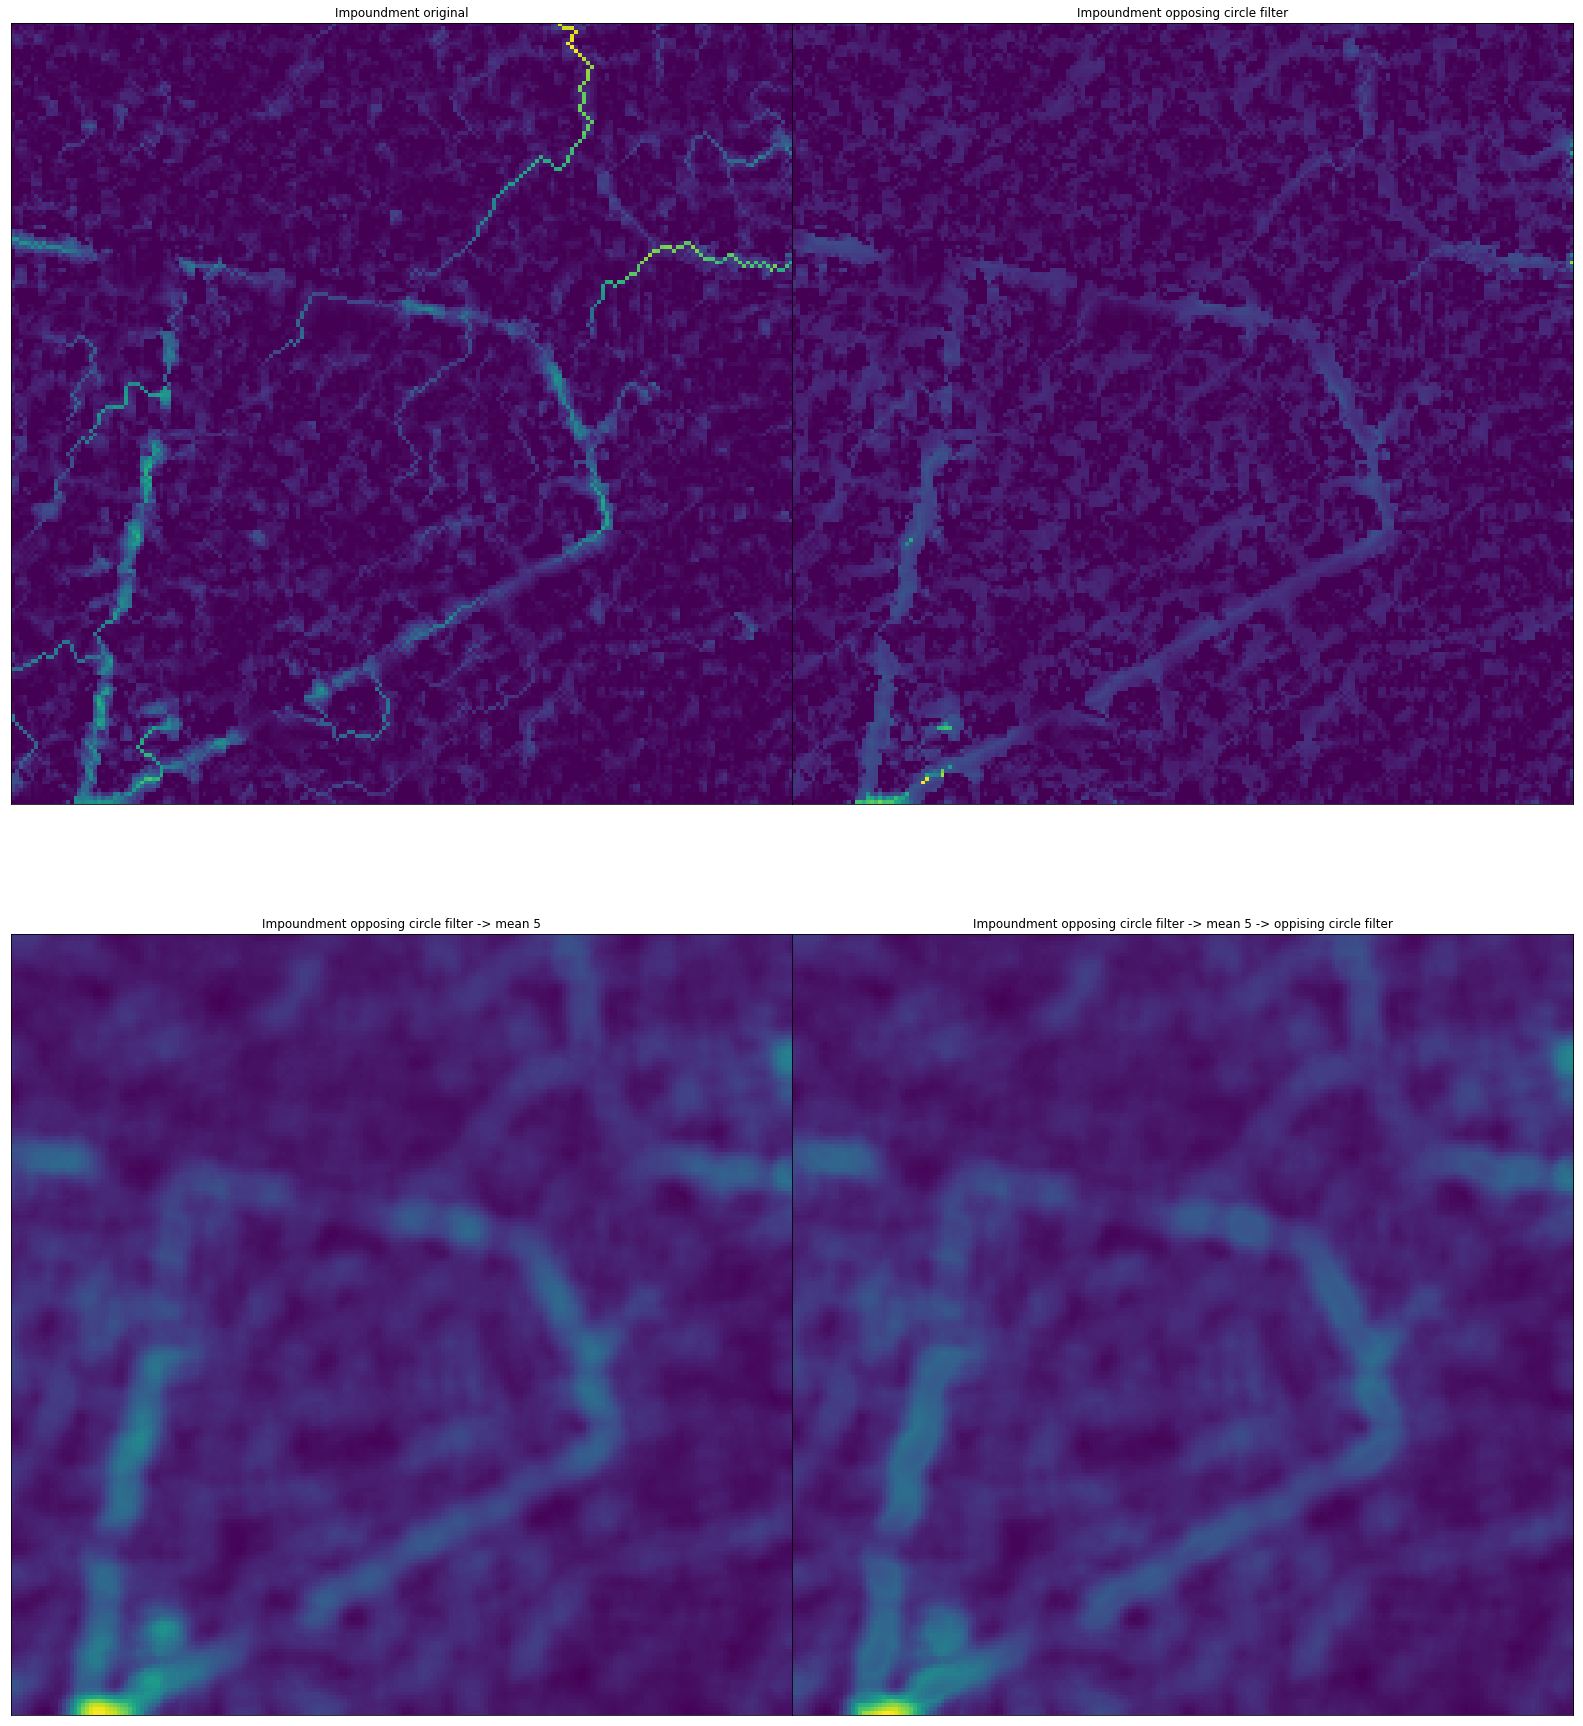

In [113]:
plt.figure(num=None, figsize=(28,32), facecolor='w', edgecolor='k')
ax = [plt.subplot(2,2,i+1) for i in range(4)]
for a in ax:
    a.set_xticklabels([])
    a.set_yticklabels([])
    a.tick_params(bottom=False, left=False)
plt.subplots_adjust(wspace=0,hspace=0.1)

mean = gf(newImpoundmentArr, np.nanmean, footprint=create_circular_mask(5))

newNewImpoundmentArr = OpposingCircleFilter(mean, 3, 6, 0.3)

for row in newNewImpoundmentArr:
    for pixel in row:
        print(pixel)

ax[0].title.set_text("Impoundment original")
ax[0].imshow(impoundmentArr)
ax[1].title.set_text("Impoundment opposing circle filter")
ax[1].imshow(newImpoundmentArr)
ax[2].title.set_text("Impoundment opposing circle filter -> mean 5")
ax[2].imshow(mean)
ax[3].title.set_text("Impoundment opposing circle filter -> mean 5 -> oppising circle filter")
ax[3].imshow(newNewImpoundmentArr)

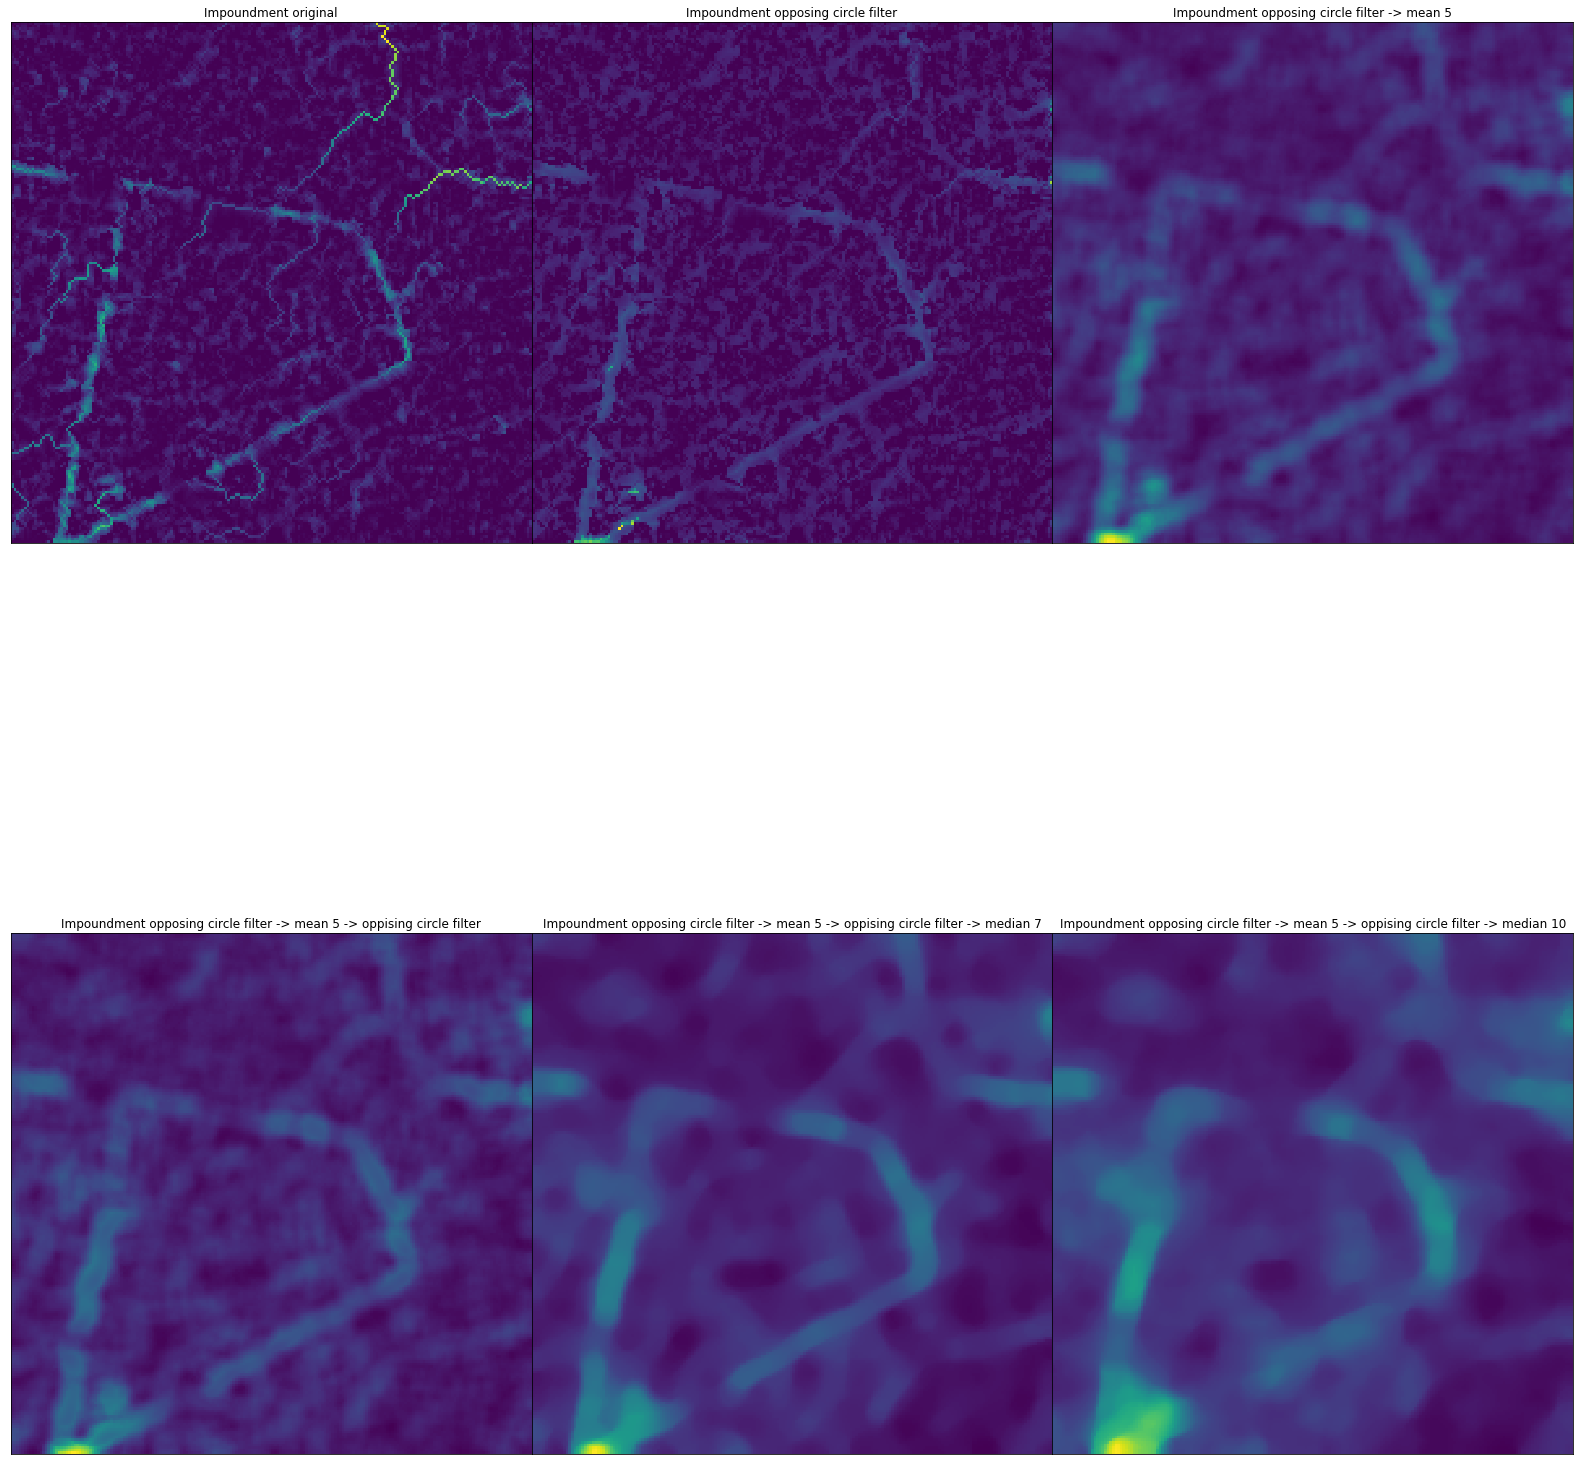

In [117]:
plt.figure(num=None, figsize=(28,32), facecolor='w', edgecolor='k')
ax = [plt.subplot(2,3,i+1) for i in range(6)]
for a in ax:
    a.set_xticklabels([])
    a.set_yticklabels([])
    a.tick_params(bottom=False, left=False)
plt.subplots_adjust(wspace=0,hspace=0.1)
'''
mean = gf(newImpoundmentArr, np.nanmean, footprint=create_circular_mask(5))

newNewImpoundmentArr = OpposingCircleFilter(mean, 3, 6, 0.3)

for row in newNewImpoundmentArr:
    for pixel in row:
        print(pixel)
'''
ax[0].title.set_text("Impoundment original")
ax[0].imshow(impoundmentArr)
ax[1].title.set_text("Impoundment opposing circle filter")
ax[1].imshow(newImpoundmentArr)
ax[2].title.set_text("Impoundment opposing circle filter -> mean 5")
ax[2].imshow(mean)
ax[3].title.set_text("Impoundment opposing circle filter -> mean 5 -> oppising circle filter")
ax[3].imshow(newNewImpoundmentArr)
ax[4].title.set_text("Impoundment opposing circle filter -> mean 5 -> oppising circle filter -> median 7")
ax[4].imshow(gf(newNewImpoundmentArr, np.nanmedian, footprint=create_circular_mask(7)))
ax[5].title.set_text("Impoundment opposing circle filter -> mean 5 -> oppising circle filter -> median 10")
ax[5].imshow(gf(newNewImpoundmentArr, np.nanmedian, footprint=create_circular_mask(10)))

In [189]:
import os

for folder in os.listdir("../cropped_data/3_zones"):
    for imageName in os.listdir(f"../cropped_data/3_zones/{folder}"):
        print(imageName)
        np.save(f"{imageName[23:-4]}_raw.npy", np.asarray(Image.open(f"../cropped_data/3_zones/{folder}/{imageName}")))


croppedImage_2625x3000_Ditches_zone1.tif
croppedImage_2625x3000_HPMF_zone1.tif
croppedImage_2625x3000_Impoundment_zone1.tif
croppedImage_2625x3000_Skyview_zone1.tif
croppedImage_2625x3000_Slope_zone1.tif
croppedImage_2625x3000_Ditches_zone2.tif
croppedImage_2625x3000_HPMF_zone2.tif
croppedImage_2625x3000_Impoundment_zone2.tif
croppedImage_2625x3000_Skyview_zone2.tif
croppedImage_2625x3000_Slope_zone2.tif
croppedImage_2625x3000_Ditches_zone3.tif
croppedImage_2625x3000_HPMF_zone3.tif
croppedImage_2625x3000_Impoundment_zone3.tif
croppedImage_2625x3000_Skyview_zone3.tif
croppedImage_2625x3000_Slope_zone3.tif


In [ ]:
#im = Image.open("../cropped_data/croppedImage_skyview130x130.tif")
#im = Image.open("../cropped_data/croppedImage_skyview200x200.tif")
#im = Image.open("../cropped_data/croppedImage_impoundment400x400.tif")
#im = Image.open("../cropped_data/croppedImage_skyview400x400.tif")
#im = Image.open("../cropped_data/croppedImage_skyview2500x2500.tif")
#im = Image.open("../cropped_data/croppedImage_skyview1000x1000.tif")
#skyViewIm = Image.open("../cropped_data/croppedImage_Skyview500x500_10299_10601_10799_11101.tif")
#skyViewArr = np.asarray(skyViewIm)
#slopeIm = Image.open("../cropped_data/croppedImage_Slope500x500.tif")
#slopeArr = np.asarray(slopeIm)
#impoundmentIm = Image.open("../cropped_data/croppedImage_Impoundment500x500.tif")
#impoundmentArr = np.asarray(impoundmentIm)
#HPMFIm = Image.open("../cropped_data/croppedImage_HPMF500x500.tif")
#HPMFArr = np.asarray(HPMFIm)
#ditchesIm = Image.open("../cropped_data/croppedImage_Ditches500x500.tif")
#ditchesArr = np.asarray(ditchesIm)

#skyViewIm = Image.open("../cropped_data/croppedImage_2625x3000_skyview_9950_8302_12575_11302.tif")
#skyViewArr = np.asarray(skyViewIm)
#slopeIm = Image.open("../cropped_data/croppedImage_2625x3000_Slope.tif")
#slopeArr = np.asarray(slopeIm)
#impoundmentIm = Image.open("../cropped_data/croppedImage_2625x3000_Impoundment.tif")
#impoundmentArr = np.asarray(impoundmentIm)
#HPMFIm = Image.open("../cropped_data/croppedImage_2625x3000_HPMF.tif")
#HPMFArr = np.asarray(HPMFIm)
#ditchesIm = Image.open("../cropped_data/croppedImage_2625x3000_Ditches.tif")
#ditchesArr = np.asarray(ditchesIm)

In [160]:
newConicArr = conicMean(skyViewArr, 5, 0.975)

circ_mask3 = create_circular_mask(3)
circ_mask4 = create_circular_mask(4)
circ_mask6 = create_circular_mask(6)
circ_mask15 = create_circular_mask(15)
circ_mask25 = create_circular_mask(25)

meanGreyOpen = morph.grey_opening(gf(newConicArr,np.nanmean,footprint=circ_mask4), footprint=circ_mask4)



np.save("hpmf_feature_means3_zone3.npy", gf(HPMFArr,np.nanmean,footprint=circ_mask3))
np.save("slope_feature_mean3_zone3.npy", gf(slopeArr,np.nanmean,footprint=circ_mask3))
np.save("impoundment_feature_mean3_zone3.npy", gf(impoundmentArr,np.nanmean,footprint=circ_mask3))
np.save("skyview_feature_cone_5_0975_mean4_opening4.npy", meanGreyOpen)
np.save("ditches_zone3.npy", ditchesArr)



575007


'\nhpmf = np.load("hpmf_feature500.npy")\nslope = np.load("slope_feature500.npy")\nimpoundment = np.load("impoundment_feature500.npy")\nskyview = np.load("skyview_feature500.npy")\n\nplt.figure(num=None, figsize=(28,26), facecolor=\'w\', edgecolor=\'k\')\nax = [plt.subplot(3,4,i+1) for i in range(12)]\nfor a in ax:\n    a.set_xticklabels([])\n    a.set_yticklabels([])\n    a.tick_params(bottom=False, left=False)\nplt.subplots_adjust(wspace=0,hspace=0)\n\n\nax[0].title.set_text("Original Slope")\nax[0].imshow(slopeArr)\n\nax[1].title.set_text("Slope mean 6")\nax[1].imshow(slope)\n\nax[2].title.set_text("Original SkyViewFactor")\nax[2].imshow(skyViewArr)\n\nax[3].title.set_text("SkyViewFactor Conic Filter: 5, 0.975,\n mean 4 grey open 4")\nax[3].imshow(skyview)\n\nax[4].title.set_text("Original Impoundment")\nax[4].imshow(impoundmentArr)\n\nax[5].title.set_text("Impoundment mean 3")\nax[5].imshow(impoundment)\n\nax[6].title.set_text("HPMF Original")\nax[6].imshow(HPMFArr)\n\nax[7].title.